# 센서 데이터를 활용한 공정 이상 예측

## `목차`
> **1. 데이터 전처리 (결측치 처리 등)**  
> **2. EDA (기술통계, 라벨 데이터 시각화)**  
> **3. 모델링 및 모델 평가 (로지스틱 회귀)**  
> **4. 모델 성능 향상**  
>> 4.1 불균형 데이터 처리를 위한 SMOTE 기법의 적용  
>> 4.2 다양한 데이터 마이닝 기법의 적용  
>> 4.3 GridSearch를 통한 랜덤포레스트의 하이퍼 파라미터 수정    
>> 4.4 불균형 데이터 처리를 위한 GAN의 적용  
>> 4.5 GAN + SMOTE
>
> **5. 모델 선택 및 센서 시각화**  

In [33]:
# 필요한 모듈 전체 임포트
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier, Booster
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import pandas.testing as tm
import pandas.util.testing as tm
from tgan.model import TGANModel

# 1. 데이터 전처리

### 1.1 데이터 생성
▶ 결측치를 0으로 대체할 것이기 때문에 `모든 튜플이 0인 열`이거나 `튜플 정보가 없는 열`을 엑셀 파일에서 수작업으로 제거   
▶ 이를 `uci-secom2.csv`로 저장하고 데이터 불러옴 (열 정보: Time, 번호로 표시된 센서, Pass/Fail)  
▶ 총 592개의 열에서 447개로 감소한 것을 확인

In [4]:
# pandas를 사용하여 csv 파일을 읽고 데이터프레임 형태로 저장
# head 괄호 안의 숫자 변경하여 출력 행의 수를 6개로 조절

data = pd.read_csv('uci-secom2.csv')
data.head(6)

,Time,0,1,2,3,4,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1
5,2008-07-19 17:53,2946.25,2432.84,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5287,0.0167,...,44.0077,0.4949,0.0189,0.0044,3.8276,0.0342,0.0151,0.0052,44.0077,-1


### 1.2 라벨 변경
▶ -1과 1로 존재하는 라벨을 0과 1로 변경  
▶ `Pass : 0`, `Fail : 1`  

In [5]:
data.loc[(data['Pass/Fail'] == -1), 'Pass/Fail']=0
data

,Time,0,1,2,3,4,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0
1,2008-07-19 12:32,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0
2,2008-07-19 13:17,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0
4,2008-07-19 15:22,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2008-10-16 15:13,2899.41,2464.36,2179.7333,3085.3781,1.4843,82.2467,0.1248,1.3424,-0.0045,...,203.1720,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720,0
1563,2008-10-16 20:49,3052.31,2522.55,2198.5667,1124.6595,0.8763,98.4689,0.1205,1.4333,-0.0061,...,NaN,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720,0
1564,2008-10-17 5:26,2978.81,2379.78,2206.3000,1110.4967,0.8236,99.4122,0.1208,NaN,NaN,...,43.5231,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231,0
1565,2008-10-17 6:01,2894.92,2532.01,2177.0333,1183.7287,1.5726,98.7978,0.1213,1.4622,-0.0072,...,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941,0


### 1.3 결측치 처리
▶ 해당 데이터는 많은 변수가 존재하여 관측을 통한 이상치 처리에 한계가 있다고 판단  
▶ 결측치를 `0으로 대체`함

In [6]:
# 결측값 확인 -> 각 컬럼에서의 결측값의 수
# 참고: data.isnull().sum().sum() -> 전체 결측값의 수

data.isnull().sum() 

Time          0
0             6
1             7
2            14
3            14
             ..
586           1
587           1
588           1
589           1
Pass/Fail     0
Length: 447, dtype: int64

In [7]:
# 결측값 0으로 대체 (replace을 사용)
# 결측값 정보를 출력
# 참고: data = data.dropna(axis=1) : 시도해봤으나 너무 많은 열정보가 삭제됨

data = data.replace(np.NaN, 0) 
data.isnull().sum()

Time         0
0            0
1            0
2            0
3            0
            ..
586          0
587          0
588          0
589          0
Pass/Fail    0
Length: 447, dtype: int64

### 1.4 Time 변수 삭제
▶ 'Time'변수의 데이터는 pass/fail을 예측하는데 큰 영향이 없다 생각하여 삭제  
▶ 447 -> 446

In [8]:
# 참고: axis=0은 행방향, axis=1은 열 방향으로 동작
# 참고: drop() 안에 삭제할 컬럼 이름을 적고 axis =1 로 정함

data = data.drop(columns = ['Time'], axis = 1)
data.shape

(1567, 446)

In [9]:
# data에서 잘 삭제되었는지 확인

data

,0,1,2,3,4,6,7,8,9,10,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,-0.0034,...,0.0000,0.5005,0.0118,0.0035,2.3630,0.0000,0.0000,0.0000,0.0000,0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,-0.0148,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,0.0013,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,-0.0033,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,-0.0072,...,0.0000,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,82.2467,0.1248,1.3424,-0.0045,-0.0057,...,203.1720,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720,0
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,98.4689,0.1205,1.4333,-0.0061,-0.0093,...,0.0000,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720,0
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,99.4122,0.1208,0.0000,0.0000,0.0000,...,43.5231,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231,0
1565,2894.92,2532.01,2177.0333,1183.7287,1.5726,98.7978,0.1213,1.4622,-0.0072,0.0032,...,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941,0


# 2. EDA

### 2.1 기술 통계

In [10]:
# 데이터프레임 정보 요약

data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 446 entries, 0 to Pass/Fail
dtypes: float64(445), int64(1)
memory usage: 5.3 MB


(1567, 446)

In [11]:
# 수치형 변수 정보 요약

data.describe()

,0,1,2,3,4,6,7,8,9,10,...,581,582,583,584,585,586,587,588,589,Pass/Fail
count,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,...,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,3002.910638,2484.700932,2180.887035,1383.901023,4.159516,100.209538,0.121122,1.460995,-0.000840,0.000146,...,38.623767,0.499777,0.015308,0.003844,3.065869,0.021445,0.016464,0.005280,99.606461,0.066369
std,200.204648,184.815753,209.206773,458.937272,56.104457,11.363940,0.012831,0.090461,0.015107,0.009296,...,72.871466,0.013084,0.017179,0.003721,3.577730,0.012366,0.008815,0.002869,93.895701,0.249005
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.053400,-0.034900,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.016900,0.000000,0.000000,0.000000,0.000000
25%,2965.670000,2451.515000,2180.700000,1080.116050,1.011000,97.762200,0.121100,1.410950,-0.010800,-0.005600,...,0.000000,0.497900,0.011600,0.003100,2.306200,0.013400,0.010600,0.003300,44.368600,0.000000
50%,3010.920000,2498.910000,2200.955600,1283.436800,1.310100,101.492200,0.122400,1.461500,-0.001300,0.000400,...,0.000000,0.500200,0.013800,0.003600,2.757600,0.020500,0.014800,0.004600,71.778000,0.000000
75%,3056.540000,2538.745000,2218.055500,1590.169900,1.518800,104.530000,0.123800,1.516850,0.008400,0.005900,...,57.449750,0.502350,0.016500,0.004100,3.294950,0.027600,0.020300,0.006400,114.749700,0.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,129.252200,0.128600,1.656400,0.074900,0.053000,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


### 2.2 라벨 데이터 시각화
▶ 라벨의 분포를 확인한 결과 `Imbalanced data`임을 확인  
▶ 추후에 `SMOTE` 기법을 통해 불균형을 해결한 후 적용 전 데이터와의 모델 성능을 비교할 것

0    1463
1     104
Name: Pass/Fail, dtype: int64

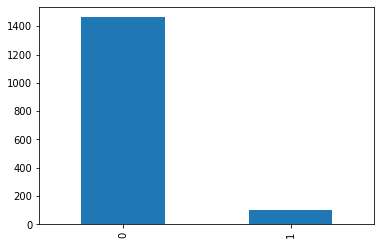

In [13]:
# Pass/Fail 분포 시각화: 막대 그래프, plot()를 사용  

data['Pass/Fail'].value_counts().plot(kind='bar')
data['Pass/Fail'].value_counts()

# 3. 모델링 및 모델 평가

### 3.1 x (feature) : y (label)
▶ feature 데이터인 `x`와 label 데이터인 `y`로 분리하기  
▶ 예측해야 할 변수인 `Pass/Fail`(y)를 제거하여 머신러닝 입력값인 x에 저장  
▶ 예측해야 할 변수 `Pass/Fail`만을 선택하여 numpy 형태로 y에 저장  

In [14]:
x = data.drop(columns = ['Pass/Fail'], axis = 1)
y = data['Pass/Fail']

# 1차원 벡터 형태로 출력하기 위해 ravel 사용 (다차원 -> 1차원)

y = y.to_numpy().ravel() 
y

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [15]:
# 타입 확인

type(y)

numpy.ndarray

### 3.2 train (8) : test (2)
▶ sklearn에서 제공하는 `train_test_split`을 사용하여 train:test 나누기  
▶ 함수 설명: train_test_split()는 호출시 무작위로 데이터를 분리  
> 파라미터 설명:   
> * test_size: 테스트 데이터의 비율
> * random_state: 호출할 때마다 동일한 학습/테스트용 데이터 세트를 생성하기 위해 주어지는 난수값  

In [17]:
# from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 486)

### 3.3 정규화
▶ 정규화를 위해서 `StandardScaler` 사용  
▶ 변수마다의 스케일 차이를 맞추기 위해 서로 다른 features의 크기를 통일함

In [18]:
# from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# x_train에 있는 데이터에 맞춰 정규화를 진행합니다. 

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_train, x_test

(array([[ 0.45404544, -0.14676931,  0.1681431 , ...,  1.28288427,
          1.6785434 , -0.4042904 ],
        [ 0.33612778,  0.53511527,  0.19944967, ..., -0.97650672,
         -1.02253354, -0.57766659],
        [ 0.23059664, -0.14928513,  0.41747369, ...,  0.22165517,
          0.32800493,  0.98659027],
        ...,
        [-0.2982879 ,  0.22364748,  0.07158656, ..., -1.27319443,
         -1.34239791, -0.79228293],
        [ 0.10884506, -0.31488496, -0.07355727, ...,  1.84202648,
          2.17611021,  0.10310491],
        [ 0.31450053, -0.05417745, -0.05560346, ..., -1.26178336,
         -1.16469548, -0.78314625]]),
 array([[ 0.34699056, -0.06147824, -0.28204339, ..., -0.4858309 ,
         -0.45388576, -0.66024398],
        [-0.46417873, -0.22086254,  0.21751559, ..., -0.36030918,
         -0.16956187, -0.72437595],
        [ 0.1121383 ,  0.09479828, -0.01402984, ..., -1.25037229,
         -1.30685743, -0.55667811],
        ...,
        [-0.86865744, -0.97669235,  0.140203  , ..., -

In [19]:
# 평균과 분산 출력

x_train_sc = pd.DataFrame(data=x_train)

print("평균")
print(x_train_sc.mean())

print("분산")
print(x_train_sc.var())

평균
0     -6.010976e-16
1      8.594537e-16
2     -6.637802e-16
3     -2.168169e-16
4      7.863711e-18
           ...     
440   -1.094274e-16
441    6.913420e-17
442    8.488377e-17
443   -2.941692e-17
444   -3.942931e-17
Length: 445, dtype: float64
분산
0      1.000799
1      1.000799
2      1.000799
3      1.000799
4      1.000799
         ...   
440    1.000799
441    1.000799
442    1.000799
443    1.000799
444    1.000799
Length: 445, dtype: float64


### 3.4 로지스틱 회귀
* 시그모이드 함수 최적선을 찾고 이 시그모이드 함수의 반환 값을 확률로 간주해 확률에 따라 분류를 결정  
* 로지스틱 회귀는 주로 이진 분류에 사용  
* 예측 값 즉, 예측 확률이 0.5 이상이면 1로, 그렇지 않으면 0으로 예측  

In [29]:
def modeling(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)     # 데이터를 학습시킬 때는 fit 함수를 사용
    pred = model.predict(x_test)
    metrics(y_test,pred)

def metrics(y_test, pred):
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred) #zero_division=1
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_score = roc_auc_score(y_test,pred,average='macro')
    print('정확도 : {0:.2f}, 정밀도 : {1:.2f}, 재현율 : {2:.2f}'.format(accuracy,precision,recall))
    print('f1-score : {0:.2f}, auc : {1:.2f}'.format(f1,roc_score,recall))

In [30]:
# max_iter는 로지스틱 알고리즘의 반복 횟수를 정하는 파라미터로 본 실습에서는 default 값으로는 모자르기에 아래와 같이 설정

LR = LogisticRegression(max_iter = 5000)
modeling(LR, x_train, x_test, y_train, y_test)
pred = LR.predict(x_test)

정확도 : 0.89, 정밀도 : 0.11, 재현율 : 0.10
f1-score : 0.11, auc : 0.52


In [31]:
cm = confusion_matrix(y_test, pred)
print(cm)

[[278  16]
 [ 18   2]]


Text(33.0, 0.5, 'Actual')

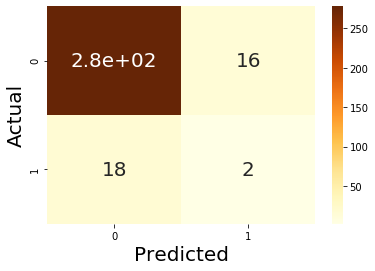

In [32]:
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap='YlOrBr')
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)

# 4. 모델 성능 향상 

### 4.1 불균형 데이터 처리를 위한 SMOTE 기법의 적용  

* 이미지 출처: https://john-analyst.medium.com/smote%EB%A1%9C-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EB%B6%88%EA%B7%A0%ED%98%95-%ED%95%B4%EA%B2%B0%ED%95%98%EA%B8%B0-5ab674ef0b32
* SMOTE 개념 참조: https://imbalanced-learn.org/stable/over_sampling.html

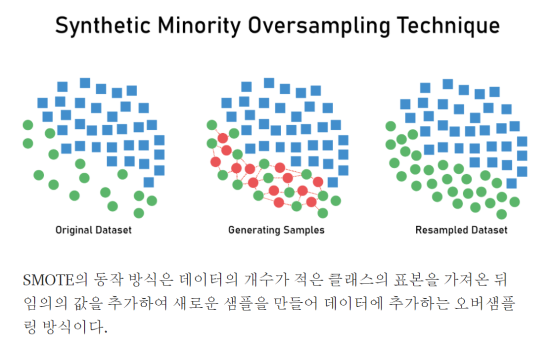

In [34]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=486)

x_train_over, y_train_over = smote.fit_resample(x_train, y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', x_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', x_train_over.shape, y_train_over.shape)
print()
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (1253, 445) (1253,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (2338, 445) (2338,)

SMOTE 적용 후 레이블 값 분포: 
 1    1169
0    1169
dtype: int64


In [35]:
modeling(LR, x_train_over, x_test, y_train_over, y_test)

정확도 : 0.84, 정밀도 : 0.11, 재현율 : 0.20
f1-score : 0.14, auc : 0.54


<span style="color:red"> => `4.1 결과` : SMOTE 기법이 유의미</span>  
<span style="color:red"> => 정확도는 감소하였으나 재현율, f1-score, auc 향상됨 </span>
* SMOTE 기법 적용 전: 정확도 : 0.89, 정밀도 : 0.11, 재현율 : 0.10, f1-score : 0.11, auc : 0.52
* SMOTE 기법 적용 후: 정확도 : 0.84, 정밀도 : 0.11, 재현율 : 0.20, f1-score : 0.14, auc : 0.54

### 4.2 다양한 데이터 마이닝 기법의 적용  

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [36]:
# 모델 append

models = []
models.append(('LR', LogisticRegression(max_iter =5000)))  #로지스틱 회귀모델 
models.append(('KNN', KNeighborsClassifier()))             # KNN 모델
models.append(('CART', DecisionTreeClassifier()))          # 의사결정트리 모델
models.append(('NB', GaussianNB()))                        # 가우시안 나이브 베이즈 모델
models.append(('RF', RandomForestClassifier()))            # 랜덤포레스트 모델
models.append(('SVM', SVC(gamma='auto')))                  # SVM 모델
models.append(('XGB', XGBClassifier()))                    # XGB 모델
models.append(('LGBM', LGBMClassifier()))                  # LGBM 모델

In [37]:
for name, model in models: 
    model.fit(x_train, y_train)
    msg = "%s - train_score : %f, test score : %f" % (name, model.score(x_train, y_train), model.score(x_test, y_test))
    print(msg)

LR - train_score : 0.979250, test score : 0.891720
KNN - train_score : 0.932961, test score : 0.936306
CART - train_score : 1.000000, test score : 0.875796
NB - train_score : 0.284916, test score : 0.270701
RF - train_score : 0.999202, test score : 0.936306
SVM - train_score : 0.939346, test score : 0.936306
XGB - train_score : 1.000000, test score : 0.936306
LGBM - train_score : 1.000000, test score : 0.936306


<span style="color:red">=> `4.2 결과` : KNN, RF, SVM, XGB, LGBM의 성능 동일 (93.63%) </span>

In [38]:
for name, model in models: 
    model.fit(x_train_over, y_train_over)
    msg = "%s - train_score : %f, test score : %f" % (name, model.score(x_train_over, y_train_over), model.score(x_test, y_test))
    print(msg)

LR - train_score : 0.986741, test score : 0.843949
KNN - train_score : 0.683490, test score : 0.334395
CART - train_score : 1.000000, test score : 0.866242
NB - train_score : 0.641146, test score : 0.305732
RF - train_score : 1.000000, test score : 0.933121
SVM - train_score : 0.997434, test score : 0.926752
XGB - train_score : 1.000000, test score : 0.933121
LGBM - train_score : 1.000000, test score : 0.933121


<span style="color:red">=> `4.2 결과` : RF, XGB, LGBM의 성능 동일 (93.31%)</span>   
=> 지금까지의 결과: 오버샘플링하지 않은 랜덤포레스트 모델 선택 (93.63%)

### 4.3 GridSearch를 통한 랜덤포레스트 하이퍼 파라미터 수정 

코드 참고: https://injo.tistory.com/30

In [68]:
# from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [10, 200],
           'max_depth' : [10, 15, 20],
           'min_samples_leaf' : [6, 8, 10],
           'min_samples_split' : [6, 8, 10]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행

rf_clf = RandomForestClassifier(random_state = 486, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 5, n_jobs = -1)
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 200}
최고 예측 정확도: 0.9330


In [69]:
#위의 결과로 나온 최적 하이퍼 파라미터로 다시 모델을 학습하여 테스트 세트 데이터에서 예측 성능을 측정

rf_clf1 = RandomForestClassifier(n_estimators = 200, 
                                max_depth = 10,
                                min_samples_leaf = 6,
                                min_samples_split = 6,
                                random_state = 486,
                                n_jobs = -1)

rf_clf1.fit(x_train, y_train)
pred = rf_clf1.predict(x_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,pred)))

예측 정확도: 0.9363


<span style="color:red">=> `4.3 결과` : 하이퍼 파라미터 설정 전과 모델 성능 동등함 (93.63%) </span>

### 4.4 불균형 데이터 처리를 위한 GAN의 적용

▶ 중요변수 30개만 포함한 데이터(uci-secom3)로 GAN 실행하여 `tgan_data` 생성  
▶ tgan_data 중 열 번호 1번인 데이터(Fail_data)와 uci-secom3를 합쳐 `uci-secom4`를 생성
* tgan_data 설명
> 행번호와 열번호는 tgan으로 모델을 생성하면서 자동으로 부여된 번호  
> 열번호는 Random Forest에서 중요도가 높다고 나온 변수의 오름차순  
> 열번호 30은 Pass/Fail 열임  

* Fail_data 설명
> tgan_data가 tgan으로 생성된 값 전체에 대한 파일  
> Fail_data는 그 중 Pass/Fail열(열번호 30)이 1에 해당하는 행만 저장한 파일

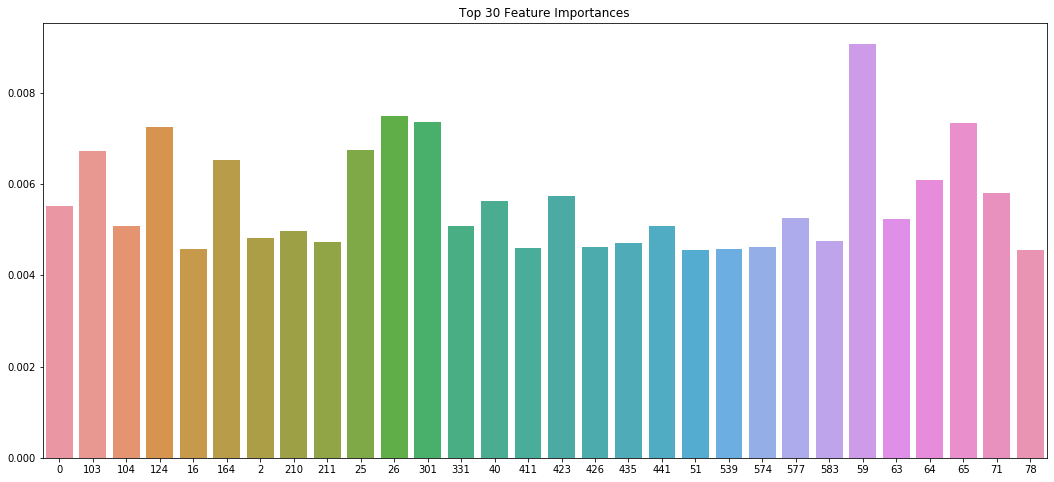

In [56]:
# 랜덤포레스트 중요 변수 Top30 확인

RF = RandomForestClassifier().fit(x_train,y_train)

%matplotlib inline
feature_names = x.columns.tolist()

ftr_importances_values = RF.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = feature_names)
ftr_top30 = ftr_importances.sort_values(ascending=False)[:30]

plt.figure(figsize=(18,8))
plt.title('Top 30 Feature Importances')
sns.barplot(x=ftr_top30.index, y=ftr_top30)
plt.show()

In [2]:
##########################
### 시간 오래 걸립니다 ###
##########################

# 중요도 top 30의 변수만 포함한 데이터 파일
# 모듈을 작동시키는데 시간이 오래 걸려 데이터양을 줄임
df = pd.read_csv('uci-secom3.csv')
df = df.replace(np.NaN, 0)
df.loc[(df['Pass/Fail'] == -1), 'Pass/Fail']=0
df = df.drop(columns = ['Time'], axis = 1)

# uci-secom3 파일에 대한 tgan 실행
# Tabular data에 대한 gan을 실행시켜주는 모듈
# 참고주소 : https://github.com/sdv-dev/TGAN
df_columns = df.columns
continuous_columns = [df.columns.get_loc(c) for c in data.select_dtypes(include=['float']).columns]

tf.reset_default_graph() # 모듈이 여러번 실행됐을 시 변수가 중복되어 발생하는 오류 해결
tgan = TGANModel(continuous_columns, batch_size = 50 )
tgan.fit(df)

# 만들어진 모델 경로에 저장
model_path = 'models/mymodel2.pkl'
tgan.save(model_path)

#만들어진 모델 csv 파일로 저장
new_tgan = TGANModel.load(model_path)
new_tgan.to_csv('tgan_data.csv')

#만들어진 데이터 중 Pass/Fail 열(tgan 데이터에서는 30번 열)이 1인 데이터만 저장
new_data = new_tgan[new_tgan[30] ==1]
new_data.to_csv('Fail_data.csv')

0    1463
1     341
Name: Pass/Fail, dtype: int64

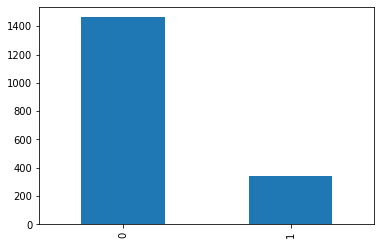

In [40]:
# uci-secom4 전처리 & 라벨 균형도 확인

secom4 = pd.read_csv('uci-secom4.csv')
secom4 = secom4.replace(np.NaN, 0)
secom4.loc[(secom4['Pass/Fail'] == -1), 'Pass/Fail']=0
secom4['Pass/Fail'].value_counts().plot(kind='bar')
secom4['Pass/Fail'].value_counts()

In [46]:
Gan_x = secom4.drop(columns = ['Pass/Fail'], axis = 1)
Gan_y = secom4['Pass/Fail']
# Gan_y = pd.to_numeric(y) #Pass/Fail 열을 숫자형으로 변환

Gan_x_train, Gan_x_test, Gan_y_train, Gan_y_test = train_test_split(Gan_x, Gan_y, test_size = 0.2, random_state = 486)
x_train_sc = pd.DataFrame(data = Gan_x_train)

sc = StandardScaler()
Gan_x_train = sc.fit_transform(Gan_x_train)
Gan_x_test = sc.transform(Gan_x_test)

In [47]:
LR = LogisticRegression(max_iter = 5000)

modeling(LR, Gan_x_train, Gan_x_test, Gan_y_train, Gan_y_test)
pred = LR.predict(Gan_x_test)

정확도 : 0.92, 정밀도 : 0.86, 재현율 : 0.66
f1-score : 0.74, auc : 0.82


[[290   7]
 [ 22  42]]


Text(33.0, 0.5, 'Actual')

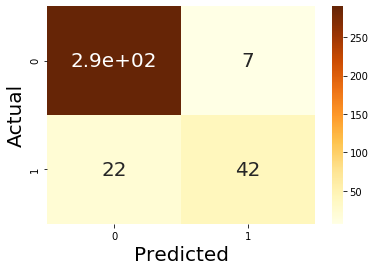

In [49]:
cm = confusion_matrix(Gan_y_test, pred)
print(cm)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap='YlOrBr')
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)

<span style="color:red">=> `4.4` 결과 : `로지스틱 회귀모델`에서의 정확도, 정밀도, 재현율, F1-Score, AUC 크게 향상됨 </span>   
<span style="color:green">=> 혹시 gan으로 생성한 데이터 덕분이 아니라 단순히 변수의 개수가 줄어들어서 성능이 좋아진건 아닐까 싶어 `uci-secom3`에 대해서도 실행해본 결과, uci-secom3에 적용한 것은 uci-secom(원본)에 적용한 것보다 `낮은 점수`가 나온 것을 확인 </span>   

### 4.5 GAN + SMOTE

In [50]:
smote = SMOTE(random_state=486)

Gan_x_train_over, Gan_y_train_over = smote.fit_resample(Gan_x_train, Gan_y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', Gan_x_train.shape, Gan_y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', Gan_x_train_over.shape, Gan_y_train_over.shape)
print()
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(Gan_y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (1443, 30) (1443,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (2332, 30) (2332,)

SMOTE 적용 후 레이블 값 분포: 
 1    1166
0    1166
Name: Pass/Fail, dtype: int64


In [53]:
for name, model in models: 
    model.fit(Gan_x_train, Gan_y_train)
    msg = "%s - train_score : %f, test score : %f"%(name, model.score(Gan_x_train, Gan_y_train), model.score(Gan_x_test, Gan_y_test))
    print(msg)
print()
print()
for name, model in models: 
    model.fit(Gan_x_train_over, Gan_y_train_over)
    msg = "%s - train_score : %f, test score : %f"%(name, model.score(Gan_x_train_over, Gan_y_train_over), model.score(Gan_x_test, Gan_y_test))
    print(msg)

LR - train_score : 0.932086, test score : 0.919668
KNN - train_score : 0.921691, test score : 0.916898
CART - train_score : 1.000000, test score : 0.875346
NB - train_score : 0.894664, test score : 0.872576
RF - train_score : 1.000000, test score : 0.936288
SVM - train_score : 0.941788, test score : 0.922438
XGB - train_score : 1.000000, test score : 0.919668
LGBM - train_score : 1.000000, test score : 0.936288


LR - train_score : 0.852916, test score : 0.844875
KNN - train_score : 0.943825, test score : 0.803324
CART - train_score : 1.000000, test score : 0.808864
NB - train_score : 0.818611, test score : 0.836565
RF - train_score : 1.000000, test score : 0.911357
SVM - train_score : 0.911235, test score : 0.867036
XGB - train_score : 1.000000, test score : 0.911357
LGBM - train_score : 1.000000, test score : 0.922438


<span style="color:red">=> `4.5 결과`:  
    ▶ SMOTE 기법이 유의미하지 않음, 전반적으로 성능 감소  
    ▶ RF, LGBM의 성능이 가장 높으며, 이는 이전에 냈던 최고 성능과 동일함 (93.63%)  
    ▶ 로지스틱 회귀, KNN, NB을 비롯한 모델링 성능을 크게 향상시키는 효과
</span>

# 5. 모델 선택 및 센서 시각화

### 5.1 랜덤포레스트 (93.63%)

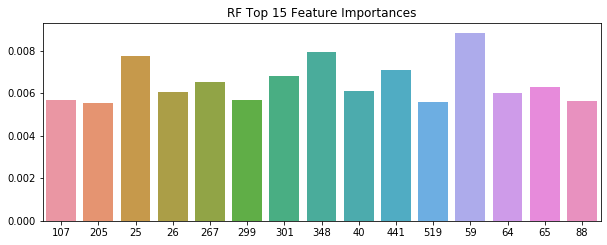

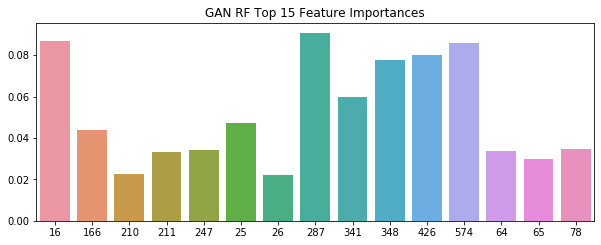

In [126]:
# 랜덤포레스트 중요 변수 Top10 확인

RF2 = RandomForestClassifier().fit(Gan_x_train, Gan_y_train)

%matplotlib inline
feature_names = x.columns.tolist()
ftr_importances_values = RF.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = feature_names)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(10,8))
plt.subplot(2, 1, 1)
plt.title('RF Top 15 Feature Importances')
sns.barplot(x=ftr_top15.index, y=ftr_top15)

feature_names = Gan_x.columns.tolist()
ftr_importances_values = RF2.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = feature_names)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(10,8))
plt.subplot(2, 1, 2)
plt.title('GAN RF Top 15 Feature Importances')
sns.barplot(x=ftr_top15.index, y=ftr_top15)
plt.show()

### 5.2 LGBM (93.63%)

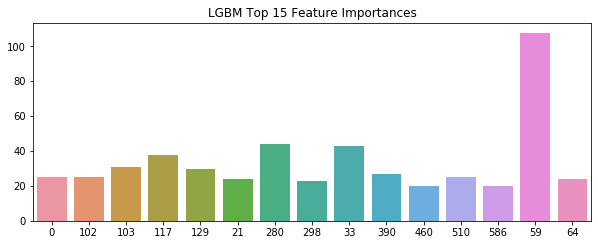

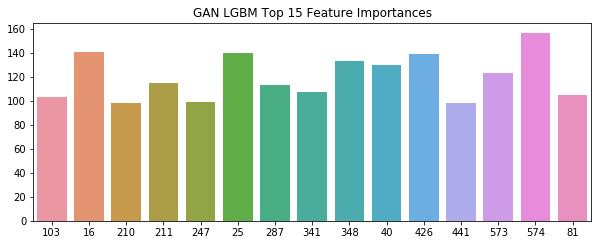

In [129]:
# LGBM 중요 변수 Top10 확인

LGBM = LGBMClassifier().fit(x_train,y_train)
LGBM2 = LGBMClassifier().fit(Gan_x_train, Gan_y_train)

%matplotlib inline
feature_names = x.columns.tolist()
ftr_importances_values = LGBM.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = feature_names)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(10,8))
plt.subplot(2, 1, 1)
plt.title('LGBM Top 15 Feature Importances')
sns.barplot(x=ftr_top15.index, y=ftr_top15)

feature_names = Gan_x.columns.tolist()
ftr_importances_values = LGBM2.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = feature_names)
ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(10,8))
plt.subplot(2, 1, 2)
plt.title('GAN LGBM Top 15 Feature Importances')
sns.barplot(x=ftr_top15.index, y=ftr_top15)
plt.show()

## Conclusion
* Gan 이전: 59번 센서가 중요
* Gan 이후: 574, 16번 센서가 중요 (RF에서는 287번 센서도 중요)

### 5.3 `59`번 센서 분포 시각화
▶ 해당 센서의 전체 분포  
▶ Pass/Fail 값이 1일 때의 분포  
▶ Pass/Fail 값이 0일 때의 분포  
=> 이를 합쳐서 동시에 출력  

Text(0.5, 1.0, '59 Sensor Measurements')

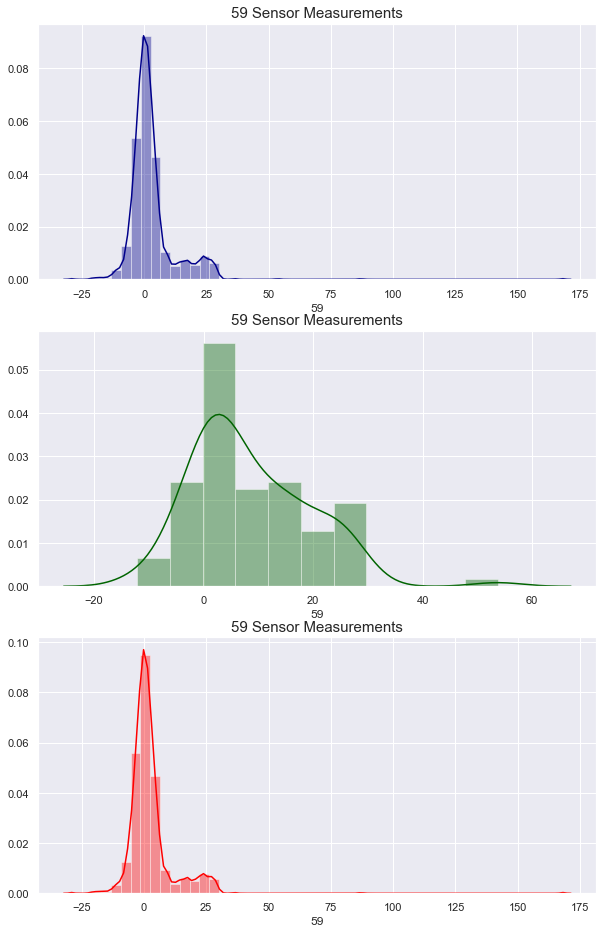

In [132]:
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (10, 16)

plt.subplot(3, 1, 1)
sns.distplot(data['59'], color = 'darkblue')
plt.title('59 Sensor Measurements', fontsize = 15)

plt.subplot(3, 1, 2)
sns.distplot(data[data['Pass/Fail']==1]['59'], color = 'darkgreen')
plt.title('59 Sensor Measurements', fontsize = 15)

plt.subplot(3, 1, 3)
sns.distplot(data[data['Pass/Fail']==0]['59'], color = 'red')
plt.title('59 Sensor Measurements', fontsize = 15)

Text(0.5, 1.0, '59 Sensor Measurements')

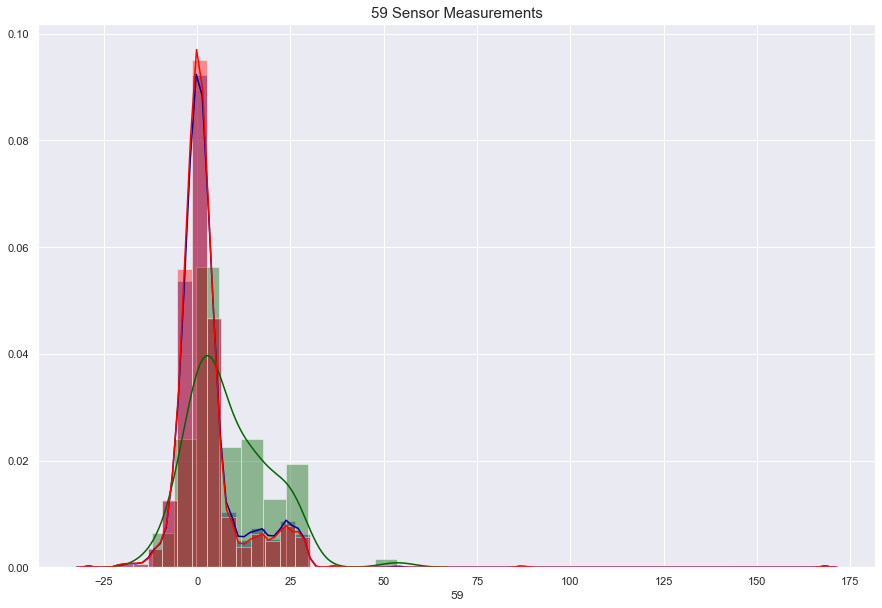

In [133]:
plt.rcParams['figure.figsize'] = (15, 10)

sns.distplot(data['59'], color = 'darkblue')
sns.distplot(data[data['Pass/Fail']==1]['59'], color = 'darkgreen')
sns.distplot(data[data['Pass/Fail']==0]['59'], color = 'red')

plt.title('59 Sensor Measurements', fontsize = 15)

### 5.4 `574` 센서 분포 시각화

Text(0.5, 1.0, '574 Sensor Measurements')

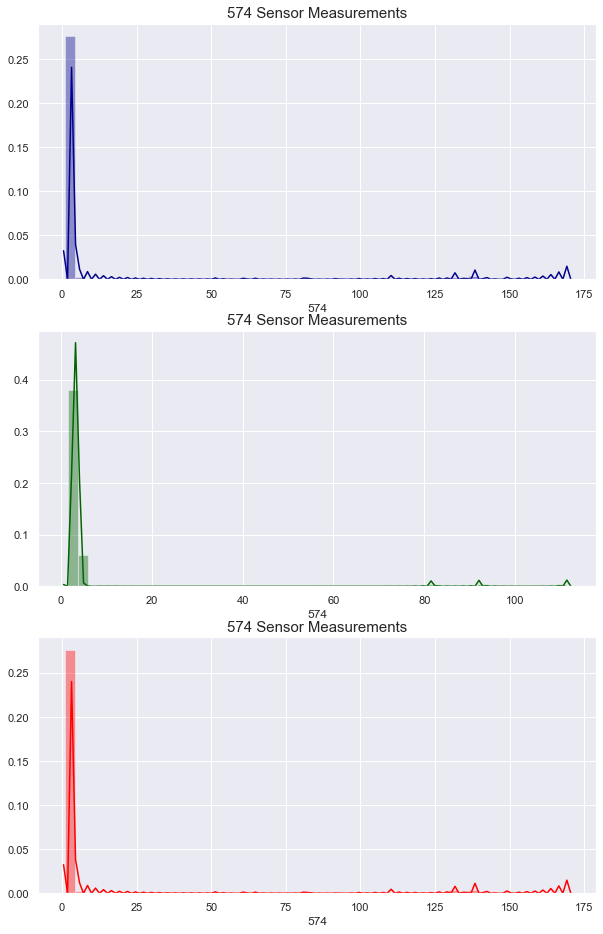

In [134]:
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (10, 16)

plt.subplot(3, 1, 1)
sns.distplot(data['574'], color = 'darkblue')
plt.title('574 Sensor Measurements', fontsize = 15)

plt.subplot(3, 1, 2)
sns.distplot(data[data['Pass/Fail']==1]['574'], color = 'darkgreen')
plt.title('574 Sensor Measurements', fontsize = 15)

plt.subplot(3, 1, 3)
sns.distplot(data[data['Pass/Fail']==0]['574'], color = 'red')
plt.title('574 Sensor Measurements', fontsize = 15)

Text(0.5, 1.0, '574 Sensor Measurements')

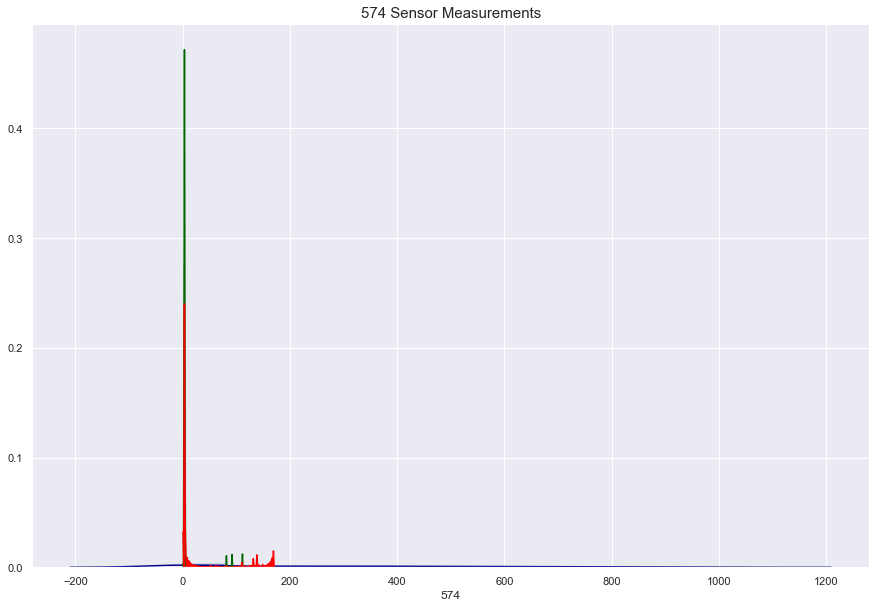

In [136]:
plt.rcParams['figure.figsize'] = (15, 10)

sns.distplot(data['486'], color = 'darkblue')
sns.distplot(data[data['Pass/Fail']==1]['574'], color = 'darkgreen')
sns.distplot(data[data['Pass/Fail']==0]['574'], color = 'red')

plt.title('574 Sensor Measurements', fontsize = 15)

### 5.5 `16` 센서 분포 시각화

Text(0.5, 1.0, '16 Sensor Measurements')

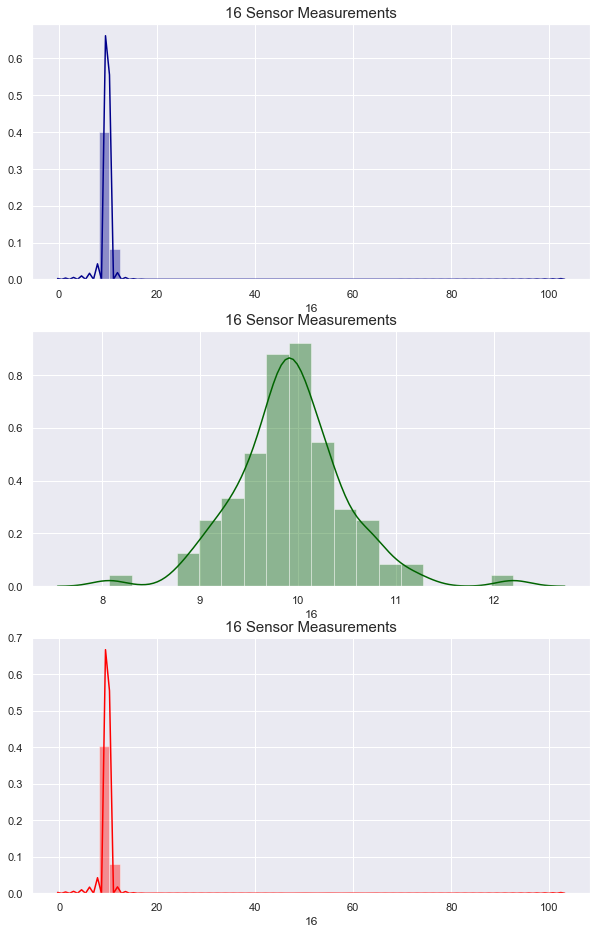

In [137]:
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (10, 16)

plt.subplot(3, 1, 1)
sns.distplot(data['16'], color = 'darkblue')
plt.title('16 Sensor Measurements', fontsize = 15)

plt.subplot(3, 1, 2)
sns.distplot(data[data['Pass/Fail']==1]['16'], color = 'darkgreen')
plt.title('16 Sensor Measurements', fontsize = 15)

plt.subplot(3, 1, 3)
sns.distplot(data[data['Pass/Fail']==0]['16'], color = 'red')
plt.title('16 Sensor Measurements', fontsize = 15)

Text(0.5, 1.0, '16 Sensor Measurements')

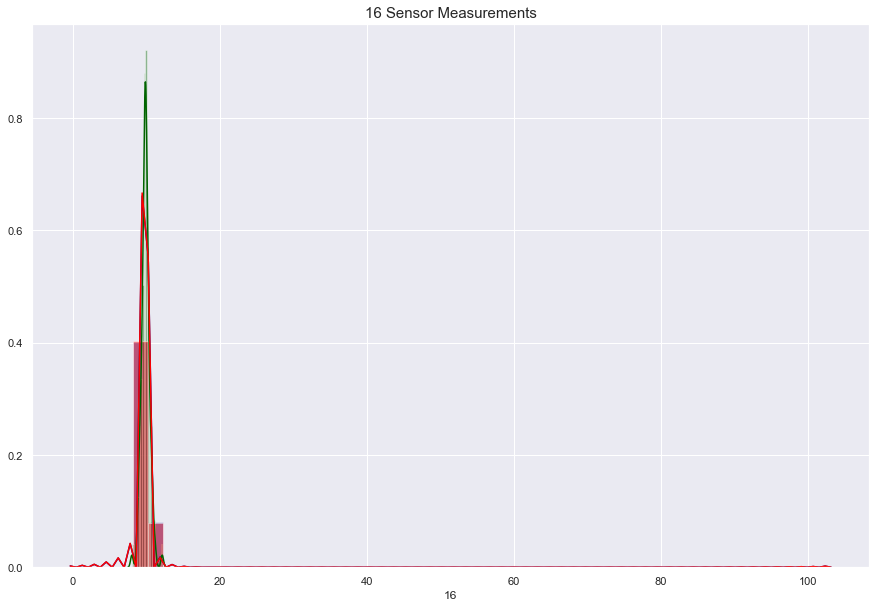

In [138]:
plt.rcParams['figure.figsize'] = (15, 10)

sns.distplot(data['16'], color = 'darkblue')
sns.distplot(data[data['Pass/Fail']==1]['16'], color = 'darkgreen')
sns.distplot(data[data['Pass/Fail']==0]['16'], color = 'red')

plt.title('16 Sensor Measurements', fontsize = 15)